# Simulación Multicapa del Transporte Iónico y Electrónico en Baterías de Estado Sólido mediante el Modelo Poisson–Nernst–Planck (PNP)

En este notebook se realiza la simulación del transporte iónico (Li⁺) y electrónico en una batería de estado sólido compuesta por múltiples capas —ánodo, electrolito sólido, cátodo e interfaces pasivas— utilizando el modelo electroquímico **Poisson–Nernst–Planck (PNP)**.

Este modelo resuelve de forma acoplada:
- La ecuación de Poisson para el potencial eléctrico en medios con diferentes permitividades.
- Las ecuaciones de Nernst–Planck para el flujo de iones en presencia de campos eléctricos y gradientes de concentración.




In [1]:
# Bloque 1: Importar librerías y definir constantes físicas fundamentales
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.animation as animation
from matplotlib.colors import ListedColormap


from IPython.display import HTML




# Constantes físicas
k_B = 1.380649e-23       # Constante de Boltzmann, J/K
q = 1.602176634e-19      # Carga elemental, C
F = 96485.3329           # Constante de Faraday, C/mol
epsilon_0 = 8.854187817e-12  # Permitividad del vacío, F/m
T = 298.15               # Temperatura en Kelvin (25ºC)
z = 1                    # Carga del ion Li+

In [2]:
# — 1) Propiedades físico-químicas de la literatura —
propiedades_lit = {
    "Al": {
        # aleación de Al comercial, σ ≃ 3,5·10⁷ S/m
        "sigma_electronica": 3.5e7,
        "difusion_ionica":      0.0,
        "permitividad_relativa": 1.0
    },
    "Al|NMC": {
        # Al₂O₃ pasivo, σ ≃ 1×10⁻⁴ Ω⁻¹·cm⁻¹ = 1×10⁻² S/m :contentReference[oaicite:0]{index=0}
        "sigma_electronica": 1e-2,
        "difusion_ionica":    1e-15,   # muy pequeño
        "permitividad_relativa": 15.0
    },
    "NMC811 (con grafeno)": {
        # LiNi₀.₈Co₀.₁Mn₀.₁O₂, σ_elec ≃ 2,1×10⁻² S/cm = 2,1 S/m :contentReference[oaicite:1]{index=1}
        "sigma_electronica": 2.1,
        "difusion_ionica":    1e-14,   # típico en catodos
        "permitividad_relativa": 20.0
    },
    "NMC|LLZO": {
        # LiNbO₃ interfase, σ_ion ≃ 10⁻⁵–10⁻⁶ S/cm = 10⁻³–10⁻⁴ S/m :contentReference[oaicite:2]{index=2}
        "sigma_electronica": 1e-8,     # aislante electrónico
        "difusion_ionica":    1e-13,
        "permitividad_relativa": 30.0
    },
    "LLZO": {
        # LLZO puro, σ_ion ≃ 2,9×10⁻⁵ S/cm = 2,9×10⁻³ S/m :contentReference[oaicite:3]{index=3}
        "sigma_electronica": 1e-10,    # aislante electrónico
        "difusion_ionica":    1e-13,
        "permitividad_relativa": 60.0
    },
    "LLZO|Li": {
        # Li₂CO₃ pasivo, σ_elec muy bajo → 1e-14 S/m (valor típico de carbonatos)
        "sigma_electronica": 1e-14,
        "difusion_ionica":    1e-14,
        "permitividad_relativa": 10.0
    },
    "Li": {
        # litio metálico, σ ≃ 1,1×10⁷ S/m :contentReference[oaicite:4]{index=4}
        "sigma_electronica": 1.1e7,
        "difusion_ionica":    1e-10,
        "permitividad_relativa": 1.1
    }
}


# — 2) Densidades base (kg/m³) y de interfaces —
densidades = {
    "Al":      2700,
    "NMC811 (con grafeno)": 4500,
    "LLZO":    5100,
    "Li":      5300
}
densidades_intf = {
    "Al|NMC":   3980,   # Al₂O₃
    "NMC|LLZO": 4647,   # LiNbO₃
    "LLZO|Li":  2110    # Li₂CO₃
}
densidades.update(densidades_intf)

# — 3) Masas molares base (kg/mol) y de interfaces —
masas_molares = {
    "Al":      0.02698,
    "NMC811 (con grafeno)": 0.0978,
    "LLZO":    0.8397,
    "Li":      0.00694
}
masas_molares_intf = {
    "Al|NMC":   0.10196,  # 101.96 g/mol
    "NMC|LLZO": 0.14785,  # 147.85 g/mol
    "LLZO|Li":  0.07389   # 73.89 g/mol
}
masas_molares.update(masas_molares_intf)

# — 4) Espesores originales de materiales base y de interfaces (m) —
espesores_mat = {
    "Al":      2.0e-5,
    "NMC811 (con grafeno)": 7.5e-5,
    "LLZO":    2.0e-4,
    "Li":      7.0e-5
}
espesores_intf = {
    "Al|NMC":   5e-8,
    "NMC|LLZO": 10e-8,
    "LLZO|Li":  10e-8
}

# — 5) Calcular espesores efectivos de materiales base (restando mitad de cada interfaz adyacente) —
espesores_ef = {}
for mat, e0 in espesores_mat.items():
    adj = [i for i in espesores_intf if mat in i.split("|")]
    descuento = sum(espesores_intf[i] for i in adj) * 0.5
    espesores_ef[mat] = e0 - descuento

# — 6) Espesores totales (materiales base efectivos + capas de interfaz completas) —
espesores_total = {**espesores_ef, **espesores_intf}

# — 7) Orden correcto para malla por regiones —
ordered_materials = [
    "Al",
    "Al|NMC",
    "NMC811 (con grafeno)",
    "NMC|LLZO",
    "LLZO",
    "LLZO|Li",
    "Li"
]

# — 8) Variable 'espesores' con sólo los espesores en ese orden —
espesores = {m: espesores_total[m] for m in ordered_materials}

# — 9) Iones Li⁺ por fórmula —
iones_por_formula = {
    "Al": 0, "NMC811 (con grafeno)": 1, "LLZO": 7, "Li": 1,
    "Al|NMC": 0, "NMC|LLZO": 1, "LLZO|Li": 2
}

# — 10) Fracción móvil de Li⁺ (solo LLZO = 0,3) —
fraccion_movil = {m: (0.3 if m == "LLZO" else 1.0) for m in espesores_total}

# — 11) Cálculos de masa y moles por m² —
masas_por_m2   = {m: densidades[m] * espesores[m] for m in ordered_materials}
moles_por_m2   = {m: masas_por_m2[m] / masas_molares[m] for m in ordered_materials}
moles_Li_eff   = {m: moles_por_m2[m] * iones_por_formula[m] * fraccion_movil[m]
                  for m in ordered_materials}

# — 12) DataFrame resumen ordenado —
df = pd.DataFrame({
    "Material":         ordered_materials,
    "Espesor (m)":      [espesores[m]       for m in ordered_materials],
    "Densidad (kg/m³)": [densidades[m]      for m in ordered_materials],
    "Masa/m² (kg/m²)":  [masas_por_m2[m]    for m in ordered_materials],
    "Moles/m²":         [moles_por_m2[m]    for m in ordered_materials],
    "Li⁺ efec./m²":     [moles_Li_eff[m]    for m in ordered_materials],
    "σ [S/m]":          [propiedades_lit[m]["sigma_electronica"] for m in ordered_materials],
    "D iónica [m²/s]":  [propiedades_lit[m]["difusion_ionica"]     for m in ordered_materials],
    "ε_r":              [propiedades_lit[m]["permitividad_relativa"] for m in ordered_materials]
})

print("Diccionario de espesores intercalados:\n", espesores)
print("\nResumen en DataFrame:\n", df)


Diccionario de espesores intercalados:
 {'Al': 1.9975e-05, 'Al|NMC': 5e-08, 'NMC811 (con grafeno)': 7.5e-05, 'NMC|LLZO': 1e-07, 'LLZO': 0.0001999, 'LLZO|Li': 1e-07, 'Li': 6.994999999999999e-05}

Resumen en DataFrame:
                Material   Espesor (m)  Densidad (kg/m³)  Masa/m² (kg/m²)  \
0                    Al  1.997500e-05              2700         0.053933   
1                Al|NMC  5.000000e-08              3980         0.000199   
2  NMC811 (con grafeno)  7.500000e-05              4500         0.337500   
3              NMC|LLZO  1.000000e-07              4647         0.000465   
4                  LLZO  1.999000e-04              5100         1.019490   
5               LLZO|Li  1.000000e-07              2110         0.000211   
6                    Li  6.995000e-05              5300         0.370735   

    Moles/m²  Li⁺ efec./m²       σ [S/m]  D iónica [m²/s]   ε_r  
0   1.998981      0.000000  3.500000e+07     0.000000e+00   1.0  
1   0.001952      0.000000  1.000000e-02 

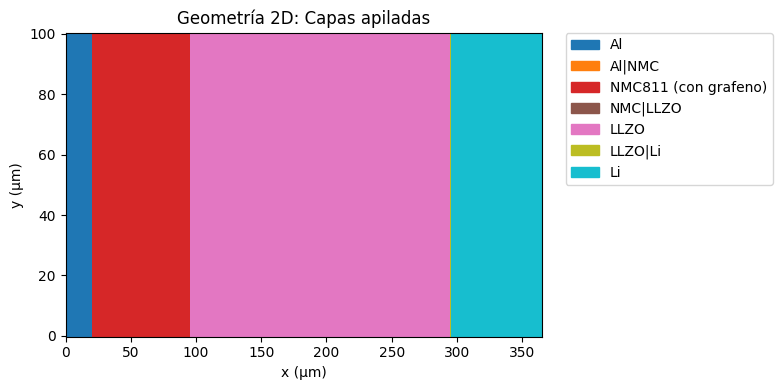

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Bloque 2: Definir malla 2D y matriz de regiones con todas las capas

# Parámetros para la malla
Ly = 100e-6  # altura fija en metros (100 μm)
Lx = sum(espesores[m] for m in ordered_materials)  # ancho total suma de espesores en x

Nx, Ny = 2500, 200  # puntos en x (espesor) y y (altura)
x = np.linspace(0, Lx, Nx)
y = np.linspace(0, Ly, Ny)
X, Y = np.meshgrid(x, y)

# Cortes acumulativos en x para asignar regiones
cortes_x = np.cumsum([espesores[m] for m in ordered_materials])

# Crear matriz de regiones usando búsqueda de índice
region = np.zeros_like(X, dtype=int)
for j, xi in enumerate(x):
    region[:, j] = np.searchsorted(cortes_x, xi)

# Visualizar la geometría
plt.figure(figsize=(8, 4))
cmap = plt.cm.tab10
plt.pcolormesh(X * 1e6, Y * 1e6, region, shading='auto', cmap=cmap)
plt.xlabel('x (μm)')
plt.ylabel('y (μm)')
plt.title('Geometría 2D: Capas apiladas')

# Leyenda con los nombres de las capas
colors = cmap(np.linspace(0, 1, len(ordered_materials)))
patches = [
    mpatches.Patch(color=colors[i], label=ordered_materials[i])
    for i in range(len(ordered_materials))
]
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

plt.tight_layout()
plt.show()


## 🔋 Fundamento físico de la simulación: distribución de cargas y ecuación de Poisson

En esta simulación, representamos el comportamiento electrostático interno de una celda de batería de estado sólido basada en un cátodo NMC811 (con recubrimiento de grafeno), un electrolito sólido LLZO y un ánodo de litio metálico.

El objetivo es resolver la ecuación de Poisson para obtener el potencial eléctrico generado por las cargas libres en el sistema. Para ello, necesitamos construir una distribución de densidad de carga realista:

\[
\nabla \cdot (\varepsilon \nabla \phi) = -\rho_{\text{total}} = -\left( \rho_{\text{Li}^+} + \rho_e \right)
\]

### ¿Qué representa cada término?

- **\( \rho_{\text{Li}^+} \)**: es la densidad volumétrica de carga positiva debida a los iones de litio móviles. Esta se construye a partir de la posición espacial de cada ion simulado. Representa las especies que realmente migran a través del electrolito.

- **\( \rho_e \)**: es la densidad de carga negativa (electrones) que permanece en el cátodo NMC811 cuando los iones Li⁺ se disocian. Estos electrones no migran a través del electrolito, pero generan campo eléctrico local y por tanto **deben incluirse en la ecuación de Poisson** para conservar el balance de cargas.

### ¿Por qué no se incluyen electrones en el LLZO o en el litio metálico?

- En **LLZO**, el transporte es puramente iónico y su conductividad electrónica es despreciable.  
- En el **ánodo de litio metálico**, los electrones se consideran perfectamente compensados por la alta densidad de portadores libres (conductores), por lo que no se produce acumulación neta de carga.

### ¿Qué implica esto para nuestra simulación?

Si solo consideráramos \( \rho_{\text{Li}^+} \), estaríamos resolviendo un caso físicamente inconsistente con una distribución de carga neta positiva, que no se da en una celda cerrada. Por tanto, introducimos también la contribución de los electrones en el cátodo, que garantiza que el campo eléctrico sea el resultado de una **disociación realista de Li⁺ + e⁻**, y no de una carga neta irreal.

Este modelo permite capturar con mayor fidelidad el perfil de potencial eléctrico y campo dentro de la celda durante estados de carga o descarga parcial.


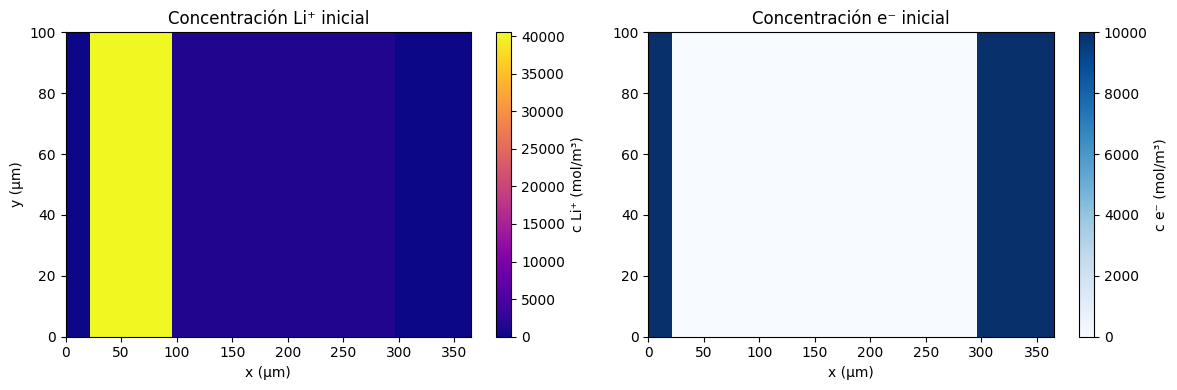

In [4]:
# 0) Reconstruir df_moles_por_m2 a partir de df, usando el nombre correcto
df_moles_por_m2 = (
    df.set_index("Material")[
        ["Espesor (m)", "Li⁺ efec./m²", "σ [S/m]", "D iónica [m²/s]", "ε_r"]
    ]
    .rename(columns={"Li⁺ efec./m²": "Moles Li⁺ efectivos por m²"})
)

# 1) Lista de materiales en orden
materials = ["Al","Al|NMC","NMC811 (con grafeno)","NMC|LLZO","LLZO","LLZO|Li","Li"]

pesos_desc = np.array([0,0,0.88,0.02,0.1,0,0])

# 1) Extraer espesores y moles/m²
espesores = df_moles_por_m2["Espesor (m)"].loc[materials].to_numpy()
moles_m2   = df_moles_por_m2["Moles Li⁺ efectivos por m²"].loc[materials].to_numpy()


#Concentración de referencia por región
c_ref_reg = moles_m2 / espesores   # mol/m³ por cada una de las 7 regiones


# 2) Crear malla y región (código previo)
x_res, y_res = 100, 50
fronteras = np.concatenate(([0], np.cumsum(espesores)))
X_vals = np.linspace(0, fronteras[-1], x_res)
Y_vals = np.linspace(0, 1e-4, y_res)
X, Y = np.meshgrid(X_vals, Y_vals)
region = np.zeros_like(X, dtype=int)
for i in range(len(materials)):
    mask = (X_vals >= fronteras[i]) & (X_vals < fronteras[i+1])
    region[:, mask] = i

# 3) Mapas de concentración
c_ion = np.zeros_like(X)  # Li⁺
c_el  = np.zeros_like(X)  # e⁻

for i, mat in enumerate(materials):
      # Concentración inicial de Li⁺ en esta región
      c0 = pesos_desc[i] * c_ref_reg[i]
      c_ion[region == i] = c0
      # Ahora los electrones:
      if mat in ["Al", "Li"]:
          # p. ej. 1e4 mol/m³ para simular alta densidad de portadores
          c_el[region == i] = 1e4
      else:
          # NMC y electrolito no tienen e⁻ móviles en el bulk
          c_el[region == i] = 0.0

# 4) Graficar ambos mapas

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Li⁺ en colormap “plasma”
im0 = axes[0].imshow(
    c_ion, origin='lower',
    extent=[X.min()*1e6, X.max()*1e6, Y.min()*1e6, Y.max()*1e6],
    aspect='auto', cmap='plasma'
)
axes[0].set_title('Concentración Li⁺ inicial')
axes[0].set_xlabel('x (μm)'); axes[0].set_ylabel('y (μm)')
plt.colorbar(im0, ax=axes[0], label='c Li⁺ (mol/m³)')

# e⁻ en colormap “Blues”
im1 = axes[1].imshow(
    c_el, origin='lower',
    extent=[X.min()*1e6, X.max()*1e6, Y.min()*1e6, Y.max()*1e6],
    aspect='auto', cmap='Blues'
)
axes[1].set_title('Concentración e⁻ inicial')
axes[1].set_xlabel('x (μm)')
plt.colorbar(im1, ax=axes[1], label='c e⁻ (mol/m³)')

plt.tight_layout()
plt.show()


In [5]:
df_moles_por_m2

,Espesor (m),Moles Li⁺ efectivos por m²,σ [S/m],D iónica [m²/s],ε_r
Material,,,,,
Al,1.997500e-05,0.000000,3.500000e+07,0.000000e+00,1.0
Al|NMC,5.000000e-08,0.000000,1.000000e-02,1.000000e-15,15.0
NMC811 (con grafeno),7.500000e-05,3.450920,2.100000e+00,1.000000e-14,20.0
NMC|LLZO,1.000000e-07,0.003143,1.000000e-08,1.000000e-13,30.0
LLZO,1.999000e-04,2.549636,1.000000e-10,1.000000e-13,60.0
LLZO|Li,1.000000e-07,0.005711,1.000000e-14,1.000000e-14,10.0
Li,6.995000e-05,53.420029,1.100000e+07,1.000000e-10,1.1


## nerst

In [6]:
import numpy as np
from scipy.constants import R, physical_constants

# --- Datos que ya tienes ---
materials = [
    "Al","Al|NMC","NMC811 (con grafeno)",
    "NMC|LLZO","LLZO","LLZO|Li","Li"
]
pesos_desc = np.array([0, 0, 0.88, 0.02, 0.1, 0, 0])  # tu distribución inicial
idx_nmc    = materials.index("NMC811 (con grafeno)")

# — Extraer datos del DataFrame —
n_max_m2 = df_moles_por_m2.loc["NMC811 (con grafeno)", "Moles Li⁺ efectivos por m²"]
d_cat    = df_moles_por_m2.loc["NMC811 (con grafeno)", "Espesor (m)"]

# 1) Concentración de referencia (SOC = 1)
c_ref = n_max_m2 / d_cat     # [mol/m³]

# 2) Concentración inicial real en el cátodo
peso_nmc = pesos_desc[idx_nmc]    # 0.88 en tu caso
c_cat0   = peso_nmc * c_ref       # [mol/m³]

# 3) SOC real
SOC_cat = peso_nmc

# 4) Calcular E_ocv con Nernst
T  = 298.15  # K
F  = physical_constants['Faraday constant'][0]  # C/mol
E0 = 4.2     # V, potencial estándar NMC vs Li/Li⁺


# Asumimos que la “actividad” en cátodo y ánodo es proporcional a su fracción de Li
a_cat = pesos_desc[materials.index("NMC811 (con grafeno)")]
a_ano = 1.0 # Actividad de 1 porque es un solido

# Evitamos log(0) y log(1) exactos
eps      = 1e-6
a_cat_cl = np.clip(a_cat, eps, 1.0 - eps)
a_ano_cl = np.clip(a_ano, eps, 1.0 - eps)


E_ocv = E0 + (R * T / F) * np.log(a_cat_cl / a_ano_cl)

# — Parámetros de carga (1 C en 1 h) —
C_rate    = 1.0   # 1 C → carga completa en 1 h
n_eff     = np.sum(df_moles_por_m2["Moles Li⁺ efectivos por m²"])      # mol/m² total
Q_area    = n_eff * F                                    # C/m²
I_app     = Q_area * C_rate / 3600.0                     # A/m²
j_boundary= I_app / F                                    # mol/(m²·s)

 # Sobretensión aproximada para control de voltaje
eta_charge = 0.1   # V, ajustable según lo rápido que quieras cargar

# Mostrar resultados
print(f"c_ref (NMC)                = {c_ref:.2e} mol/m³")
print(f"SOC (Li en cátodo)         = {SOC_cat:.2%}")
print(f"Actividad cátodo (a_cat)   = {a_cat_cl:.2%}")
print(f"Actividad ánodo (a_ano)    = {a_ano_cl:.2%}")
print(f"Potencial OCV calculado     = {E_ocv:.4f} V")

c_ref (NMC)                = 4.60e+04 mol/m³
SOC (Li en cátodo)         = 88.00%
Actividad cátodo (a_cat)   = 88.00%
Actividad ánodo (a_ano)    = 100.00%
Potencial OCV calculado     = 4.1967 V


### Consideración de los electrones en la ecuación de Poisson

En esta simulación del perfil electrostático de una batería de estado sólido, hemos considerado inicialmente la densidad de carga debida únicamente a los iones \( \text{Li}^+ \). Sin embargo, esta aproximación es incompleta en ciertas regiones del sistema, especialmente en el cátodo NMC811, por las siguientes razones:

- **NMC811 es un material electrónicamente conductor**, ya que los metales de transición como Ni, Mn y Co pueden cambiar su estado de oxidación durante los procesos de carga y descarga. Esta variación implica una transferencia de electrones hacia o desde el colector de corriente, generando una densidad local de portadores de carga negativa (electrones).
  
- Estos **electrones móviles contribuyen directamente a la densidad de carga total \( \rho \)** que aparece en la ecuación de Poisson, y su efecto no puede despreciarse sin comprometer la validez del perfil de potencial obtenido.

Por otro lado, el resto de materiales presentan las siguientes características:

- **LLZO**: Es un electrolito sólido iónico con una gran banda prohibida y prácticamente sin conductividad electrónica. Por tanto, no aporta electrones libres a \( \rho \).
  
- **Litio metálico y aluminio**: Al ser metales, sus electrones libres se redistribuyen de forma que el campo eléctrico interno es nulo en condiciones de equilibrio. Toda la carga se sitúa en la superficie, por lo que **no se modela como densidad volumétrica de carga**.

Por tanto, a partir de este punto, **añadiremos al término \( \rho \) una contribución negativa proveniente de la densidad de electrones en la región del NMC811**:
\[
\rho_{\text{total}}(x, y) = e \cdot n_{\text{Li}^+}(x, y) - e \cdot n_{e^-}(x, y)
\]
donde \( n_{e^-} \) será evaluado en función del estado de carga del cátodo.


### Interpolar la distribución de carga ρ(x,y)

### electroneutralidad en el cátodo NMC

Cuando desintercalas Li⁺ de LiₓNMC al descargar la celda:

1. **Reacción de desintercalación**  
   \[
     \mathrm{Li}_x\mathrm{NMC}
       \;\longrightarrow\;
     \mathrm{Li}^+_{\,(electrolito)} \;+\;
     e^-_{\,(red)} \;+\;
     \mathrm{NMC}_{x-1}
   \]  
   - El ion Li⁺ sale al electrolito.  
   - El electrón **no** circula libre por el electrolito, sino que se “alojará” en la red de óxidos de NMC (reduce un metal de transición).

2. **Electroneutralidad local**  
   - Cada Li⁺ móvil va acompañado de un **electrón ligado** en la estructura cristalina.  
   - Estos electrones “químicos” no se modelan como portadores libres (`c_el`), sino como carga de red fija que compensa \(c_{Li^+}\).  
   - Por eso en el **bulk** del NMC la densidad neta de carga  
     \(\rho = F\bigl(c_{Li^+} - c_{e^-}^{\rm ligado}\bigr)\approx 0\).

3. **Implicación numérica**  
   - Asumir electroneutralidad evita campos eléctricos irreales en el dominio.  
   - Solo en la capa de doble-capa (nm) junto a la interfase aparece un pequeño desbalance.  
   - A escala micrométrica, basta resolver  
     \[
       ∇·(σ_e∇φ)=0
     \]
     en el cátodo, sin acumular ρ neta en el bulk.


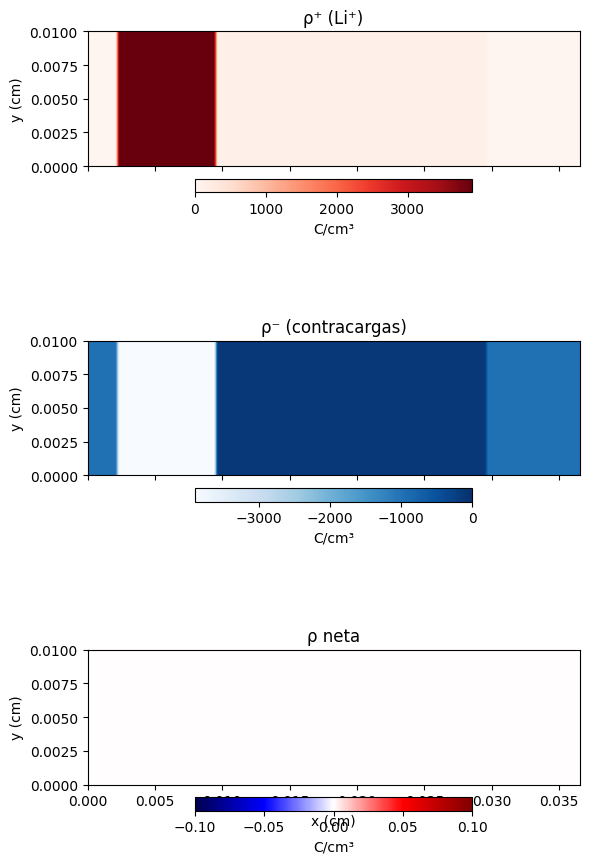

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.constants import physical_constants

# 1) Constante de Faraday
F = physical_constants['Faraday constant'][0]  # C/mol

# 2) Construir todas las contracargas

# 2a) Electrones “ligados” en NMC (compensan Li⁺ intercalado)
idx_nmc    = materials.index("NMC811 (con grafeno)")
mask_nmc   = (region == idx_nmc)
c_e_ligado = np.zeros_like(c_ion)
c_e_ligado[mask_nmc] = c_ion[mask_nmc]

# 2b) Anión fijo en el electrolito (compensa Li⁺ móviles)
ionic = [materials.index(m) for m in ("LLZO","NMC|LLZO","LLZO|Li")]
c_anion = np.zeros_like(c_ion)
for i in ionic:
    c_anion[region == i] = c_ion[region == i]

# 2c) Electrones libres y iones de red en Al y Li-metal
metal = [materials.index("Al"), materials.index("Li")]
c_e_free  = np.zeros_like(c_ion)
c_lattice = np.zeros_like(c_ion)
for i in metal:
    m = (region == i)
    c_e_free[m]  = c_el[m]
    c_lattice[m] = c_el[m]   # mismos moles/m³ de iones de red

# 3) Densidades de carga en C/m³
rho_Li       =  F * c_ion           # Li⁺
rho_e_bound  = -F * c_e_ligado      # e⁻ ligado en NMC
rho_e_free   = -F * c_e_free        # e⁻ libres en metales
rho_anion    = -F * c_anion         # anión fijo en electrolito
rho_lattice  =  F * c_lattice       # iones de red en metales

# 4) Densidad neta de carga
rho_tot_m3 = rho_Li + rho_e_bound + rho_e_free + rho_anion + rho_lattice

# 5) Convertir a C/cm³
rho_pos_cm3 = rho_Li      / 1e6
rho_neg_cm3 = (rho_e_bound + rho_e_free + rho_anion) / 1e6
rho_tot_cm3 = rho_tot_m3  / 1e6

# 6) Límites de visualización (percentil 99)
vmax_p = np.percentile(rho_pos_cm3, 99)
vmax_n = np.percentile(np.abs(rho_neg_cm3), 99)
vmax_t = np.percentile(np.abs(rho_tot_cm3), 99)

# 7) Graficar en vertical con colorbars horizontales y tamaño ajustado
extent = [X.min()*1e2, X.max()*1e2, Y.min()*1e2, Y.max()*1e2]
fig, axs = plt.subplots(3, 1, figsize=(6, 10), sharex=True)

# Parámetros para las colorbars horizontales
cb_kwargs = dict(orientation='horizontal', fraction=0.045, pad=0.04)

# ρ⁺ (Li⁺)
im0 = axs[0].imshow(rho_pos_cm3, origin='lower', extent=extent,
                    cmap='Reds', vmin=0, vmax=vmax_p)
axs[0].set(title='ρ⁺ (Li⁺)', ylabel='y (cm)')
fig.colorbar(im0, ax=axs[0], label='C/cm³', **cb_kwargs)

# ρ⁻ (e⁻ ligado + libre + anión)
im1 = axs[1].imshow(rho_neg_cm3, origin='lower', extent=extent,
                    cmap='Blues', vmin=-vmax_n, vmax=0)
axs[1].set(title='ρ⁻ (contracargas)', ylabel='y (cm)')
fig.colorbar(im1, ax=axs[1], label='C/cm³', **cb_kwargs)

# ρ neta
im2 = axs[2].imshow(rho_tot_cm3, origin='lower', extent=extent,
                    cmap='seismic', vmin=-vmax_t, vmax=vmax_t)
axs[2].set(title='ρ neta', xlabel='x (cm)', ylabel='y (cm)')
fig.colorbar(im2, ax=axs[2], label='C/cm³', **cb_kwargs)

plt.tight_layout()
plt.show()


### Conductividad ionica

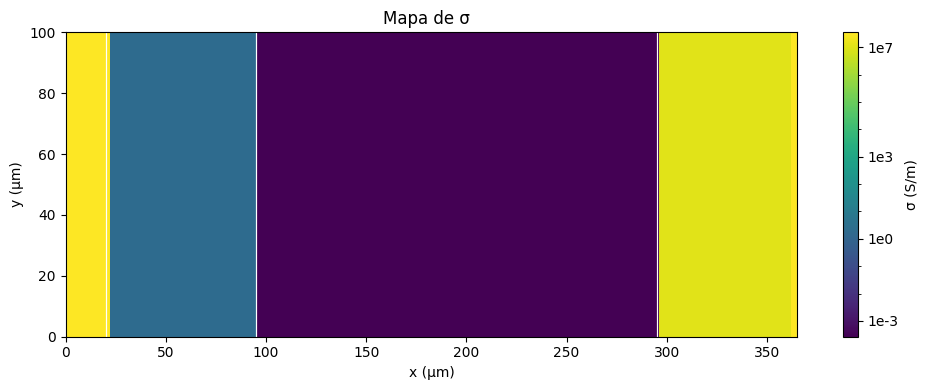

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.constants import R, physical_constants

# — Constantes —
F = physical_constants['Faraday constant'][0]  # C/mol
T = 298.15                                    # K

# — Materiales en orden y malla preexistente —
materials = [
    "Al", "Al|NMC", "NMC811 (con grafeno)",
    "NMC|LLZO", "LLZO", "LLZO|Li", "Li"
]
# region[i,j] ∈ [0..6] ya mapea cada celda a un material

# — Extraer vectores de propiedades por material —
D_vec    = df_moles_por_m2["D iónica [m²/s]"].loc[materials].to_numpy()
sigma_el = df_moles_por_m2["σ [S/m]"].loc[materials].to_numpy()

# — Concentración de Li⁺ en mol/m³ por celda (c_ion) ya calculada —
# c_ion[i,j] = concentración en región "materials[ region[i,j] ]"

# — Construcción de σ_xy combinando electrónica e iónica —
sigma_xy = sigma_el[region]  # primero, por defecto electrónica en todo

# índices de regiones iónicas (electrolito y sus interfases)
ion_idx = [
    materials.index("NMC|LLZO"),
    materials.index("LLZO"),
    materials.index("LLZO|Li")
]

# aplicar ley de Nernst–Einstein en esas regiones
for idx in ion_idx:
    mask = (region == idx)
    D_loc = D_vec[idx]
    # c_ion[mask] en mol/m³
    sigma_xy[mask] = D_loc * F**2 * c_ion[mask] / (R * T)


from matplotlib.colors import SymLogNorm

# — Parámetros para SymLogNorm —
linthresh = 1e-3   # umbral lineal ±1e-3 S/m
linscale  = 1.0    # “ancho” de la zona lineal
vmin      = np.min(sigma_xy[sigma_xy>0])
vmax      = np.max(sigma_xy)

norm = SymLogNorm(linthresh=linthresh,
                  linscale=linscale,
                  vmin=vmin,
                  vmax=vmax)

# — Plot —
fig, ax = plt.subplots(figsize=(10,4))
im = ax.imshow(
    sigma_xy,
    origin='lower',
    extent=[X.min()*1e6, X.max()*1e6, Y.min()*1e6, Y.max()*1e6],
    aspect='auto',
    cmap='viridis',
    norm=norm
)
cbar = fig.colorbar(im, ax=ax, label='σ (S/m)', ticks=[
    1e-15, 1e-10, 1e-5, 1e-3, 1e0, 1e3, 1e7
])
cbar.ax.set_yticklabels([
    '1e-15','1e-10','1e-5','1e-3','1e0','1e3','1e7'
])

# Fronteras de capa
for xb in fronteras*1e6:
    ax.axvline(xb, color='white', lw=0.8)

ax.set_title('Mapa de σ  ')
ax.set_xlabel('x (μm)')
ax.set_ylabel('y (μm)')
plt.tight_layout()
plt.show()


In [9]:
# extraigo vectores de tu DataFrame
sigma_el_vec = df_moles_por_m2["σ [S/m]"].loc[materials].to_numpy()
D_vec        = df_moles_por_m2["D iónica [m²/s]"].loc[materials].to_numpy()

# map(a) = sea a la región (0..6)
sigma_xy = sigma_el_vec[region]    # por defecto electrónica

ion_idx = [ materials.index("NMC|LLZO"), materials.index("LLZO") ]
for idx in ion_idx:
    mask = region == idx
    Dloc = D_vec[idx]
    sigma_xy[mask] = Dloc * F**2 * c_ion[mask] / (R*T)

# (opcional) inspección rápida:
print("σ en LLZO (min,max):", sigma_xy[region==materials.index("LLZO")].min(),
                                sigma_xy[region==materials.index("LLZO")].max())


σ en LLZO (min,max): 0.00047898168904339413 0.00047898168904339413


### Potencial electroestatico. ec de poisson

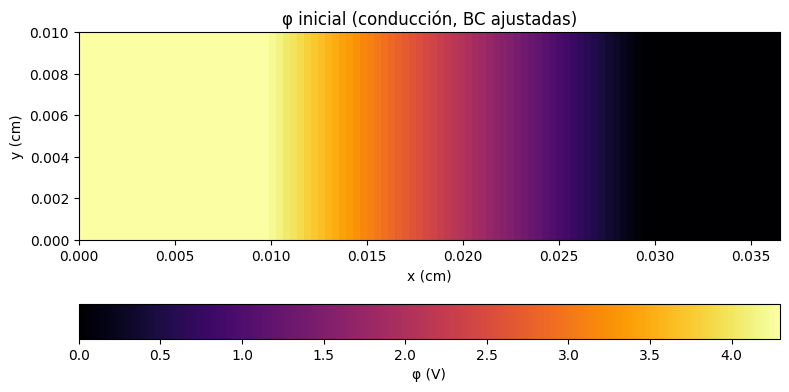

E_ocv + η = 4.196715656680707 0.1
Inicio NMC en columna j = 6 de 100


In [10]:
def compute_and_plot_phi1(E_ocv):
    import numpy as np
    from scipy.sparse import lil_matrix
    from scipy.sparse.linalg import spsolve
    import matplotlib.pyplot as plt

    # — Malla y parámetros —
    Ny, Nx = region.shape
    dx = X[0,1] - X[0,0]
    dy = Y[1,0] - Y[0,0]
    N  = Ny * Nx

    def idx_lin(i, j):
        return i * Nx + j

    # — Vector b = 0 para ∇·(σ∇φ)=0 —
    A = lil_matrix((N, N))
    b = np.zeros(N)

    # Columna donde empieza NMC (para BC Dirichlet)
    idx_nmc     = materials.index("NMC811 (con grafeno)")
    j_nmc_start = np.where(region[0,:] == idx_nmc)[0][0]

    # — Montaje de A con BC y conducción —
    for i in range(Ny):
        for j in range(Nx):
            k = idx_lin(i, j)

            # Neumann en colector Al (izquierda): ∂φ/∂x = 0
            if j == 0:
                A[k,k]             =  1
                A[k,idx_lin(i,j+1)] = -1

            # Dirichlet en frontal NMC: φ = E_ocv + η_charge
            elif j == j_nmc_start:
                A[k,k] = 1
                b[k]   = E_ocv + eta_charge

            # Dirichlet en ánodo Li (derecha): φ = 0
            elif j == Nx-1:
                A[k,k] = 1
                b[k]   = 0

            # Neumann arriba/abajo: ∂φ/∂y = 0
            elif i == 0:
                A[k,k]               =  1
                A[k,idx_lin(i+1,j)] = -1
            elif i == Ny-1:
                A[k,k]               =  1
                A[k,idx_lin(i-1,j)] = -1

            # Interior: discretización de ∇·(σ∇φ)=0
            else:
                sl = sigma_xy[i,   j-1]
                sr = sigma_xy[i,   j+1]
                su = sigma_xy[i-1, j  ]
                sd = sigma_xy[i+1, j  ]

                A[k,k]               = -(sl+sr)/dx**2 - (su+sd)/dy**2
                A[k,idx_lin(i, j-1)] =  sl/dx**2
                A[k,idx_lin(i, j+1)] =  sr/dx**2
                A[k,idx_lin(i-1, j)] =  su/dy**2
                A[k,idx_lin(i+1, j)] =  sd/dy**2

    # — Resolver y reshapar —
    phi = spsolve(A.tocsr(), b).reshape((Ny, Nx))

    # — Graficar φ en cm —
    fig, ax = plt.subplots(figsize=(8,4))
    im = ax.imshow(
        phi,
        origin='lower',
        extent=[X.min()*1e2, X.max()*1e2, Y.min()*1e2, Y.max()*1e2],
        aspect='auto',
        cmap='inferno'
    )
    cbar = fig.colorbar(im, ax=ax, orientation='horizontal', pad=0.2)
    cbar.set_label('φ (V)')
    ax.set_title('φ inicial (conducción, BC ajustadas)')
    ax.set_xlabel('x (cm)')
    ax.set_ylabel('y (cm)')
    plt.tight_layout()
    plt.show()

    print("E_ocv + η =", E_ocv, eta_charge)
    print("Inicio NMC en columna j =", j_nmc_start, "de", Nx)

    return phi


phi_initial = compute_and_plot_phi1(E_ocv)


La gráfica muestra la solución de la ecuación de Poisson para el potencial eléctrico φ(x, y), obtenida a partir de la distribución espacial realista de densidad de carga ρ(x, y) en la celda de batería.

Se observa un descenso marcado del potencial hacia la derecha, lo cual es coherente con una mayor acumulación de iones Li⁺ (carga positiva) en esa región. Este comportamiento refleja correctamente el efecto electrostático generado por la distribución no homogénea de carga: el potencial decrece en dirección del campo eléctrico, que apunta desde la zona de mayor potencial (menos cargada) hacia la de menor potencial (más cargada positivamente).

Este perfil es característico de una batería en proceso de descarga, donde los iones migran del ánodo (Li metálico, izquierda) al cátodo (NMC811, derecha), generando una diferencia de potencial impulsada por el gradiente de carga.

La resolución de Poisson con condiciones de contorno físicas (potenciales fijados en los extremos) y permitividad espacialmente variable permite capturar con mayor realismo los efectos interfaciales y dieléctricos en el comportamiento eléctrico de la batería.


### Campo Electrico

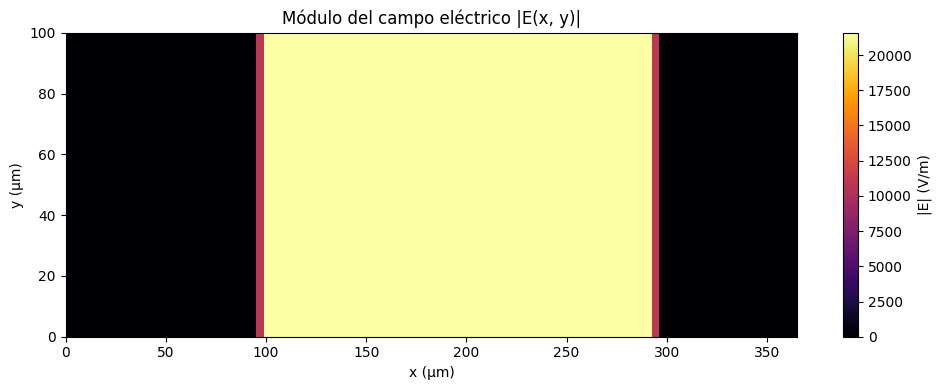

In [11]:
import numpy as np
import matplotlib.pyplot as plt

# Asumimos que ya tienes phi_2D, X, Y definidos

# Calcular el gradiente del potencial
dy = Y[1, 0] - Y[0, 0]
dx = X[0, 1] - X[0, 0]

Ey, Ex = np.gradient(-phi_initial, dy, dx)  # ¡Ojo! Gradiente negativo

# Visualización del módulo del campo eléctrico
E_magnitude = np.sqrt(Ex**2 + Ey**2)

plt.figure(figsize=(10, 4))
plt.imshow(E_magnitude, extent=[X.min()*1e6, X.max()*1e6, Y.min()*1e6, Y.max()*1e6],
           origin='lower', aspect='auto', cmap='inferno')
plt.colorbar(label='|E| (V/m)')
plt.xlabel('x (μm)')
plt.ylabel('y (μm)')
plt.title('Módulo del campo eléctrico |E(x, y)|')
plt.tight_layout()
plt.grid(False)
plt.show()


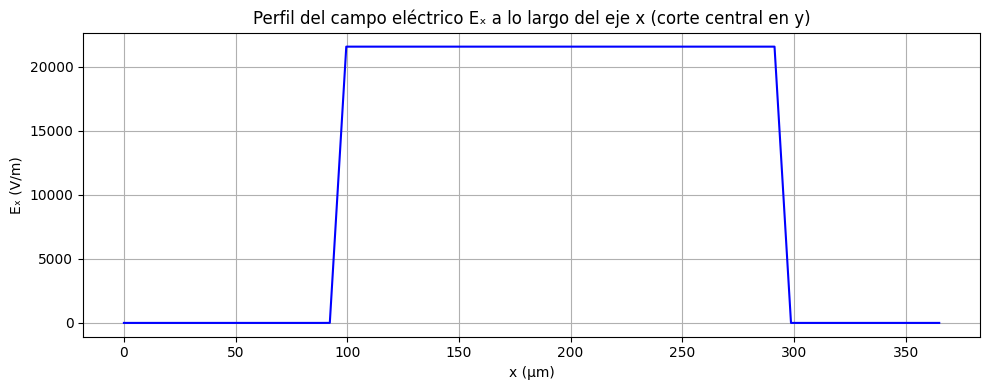

In [12]:
# Calcular correctamente las derivadas parciales usando np.gradient por separado
dphi_dy = np.gradient(phi_initial, axis=0) / (Y[1, 0] - Y[0, 0])
dphi_dx = np.gradient(phi_initial, axis=1) / (X[0, 1] - X[0, 0])

Ey = -dphi_dy
Ex = -dphi_dx

# Paso 2: Graficar perfil Ex(x) en la línea central y = const
y_central_index = Y.shape[0] // 2
Ex_corte = Ex[y_central_index, :]
x_vals_micras = X[0, :] * 1e6

plt.figure(figsize=(10, 4))
plt.plot(x_vals_micras, Ex_corte, color='blue')
plt.xlabel('x (μm)')
plt.ylabel('Eₓ (V/m)')
plt.title('Perfil del campo eléctrico Eₓ a lo largo del eje x (corte central en y)')
plt.grid(True)
plt.tight_layout()
plt.show()


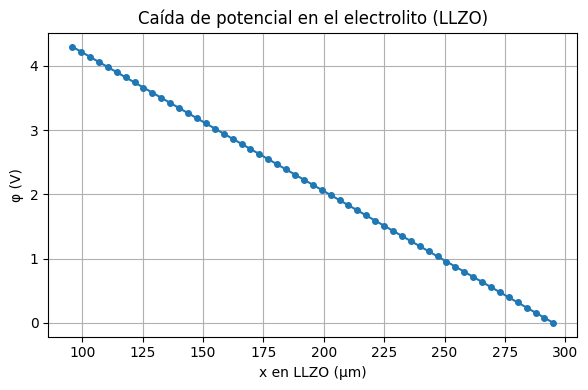

Δφ en LLZO = 4.297 V


In [13]:
import numpy as np
import matplotlib.pyplot as plt

# — Asumimos que ya tienes en memoria:
#    X_vals, phi_2D, region, materials

# 1) Encuentra el índice de la capa LLZO
idx_llzo = materials.index("LLZO")

# 2) Averigua las columnas donde empieza y termina LLZO
cols_ok = np.where(region[0, :] == idx_llzo)[0]
j0, j1 = cols_ok[0], cols_ok[-1]

# 3) Coge el corte central en y
mid_y = phi_initial.shape[0] // 2
phi_corte = phi_initial[mid_y, :]  # φ vs j

# 4) Extrae solo la parte de LLZO
x_zoom = X_vals[j0:j1+1] * 1e6   # en μm
phi_zoom = phi_corte[j0:j1+1]

# 5) Gráfica
plt.figure(figsize=(6,4))
plt.plot(x_zoom, phi_zoom, '-o', markersize=4)
plt.xlabel('x en LLZO (μm)')
plt.ylabel('φ (V)')
plt.title('Caída de potencial en el electrolito (LLZO)')
plt.grid(True)
plt.tight_layout()
plt.show()

# 6) Diferencia total de potencial en LLZO
dphi = phi_zoom[0] - phi_zoom[-1]
print(f"Δφ en LLZO = {dphi:.3f} V")


## Flujo iónico \(\mathbf J\)

A partir de la distribución inicial de concentración de Li\(^+\) y del potencial eléctrico resuelto por Poisson, calculamos el flujo iónico bidimensional

\[
\mathbf J \;=\; -D\,\nabla c \;+\;\mu\,c\,\mathbf E
\quad\bigl[\mathrm{mol}\,/(\mathrm{m}^2\cdot\mathrm s)\bigr],
\]

donde:
- \(D(x,y)\) es el coeficiente de difusión iónica de cada capa (propiedades\_lit).
- \(c(x,y)\) la concentración molar de Li\(^+\) (convertida desde \(\rho^+\)).
- \(\mu = \tfrac{D\,F}{R\,T}\) la movilidad iónica (Einstein–Smoluchowski).
- \(\mathbf E = -\nabla\phi\) el campo eléctrico obtenido de Poisson.



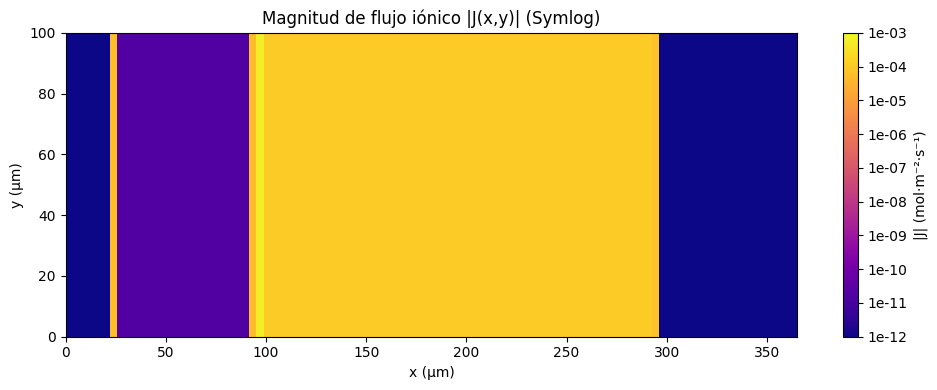

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.constants import R, physical_constants
from matplotlib.colors import SymLogNorm  # o LogNorm

# — Constantes físicas —
F = physical_constants['Faraday constant'][0]  # C/mol
T = 298.15                                     # K
z = 1

# — 1) Construir D_ion_xy incluyendo difusión en el cátodo —
D_ion_xy = np.zeros_like(phi_initial)
for mat in ("NMC811 (con grafeno)", "NMC|LLZO", "LLZO", "LLZO|Li"):
    idx = materials.index(mat)
    D_ion_xy[region == idx] = propiedades_lit[mat]["difusion_ionica"]

# — 2) Movilidad μ = D·F/(R·T) —
mu_xy = D_ion_xy * F / (R * T)

# — 3) Pasos de la malla —
dy = Y[1,0] - Y[0,0]
dx = X[0,1] - X[0,0]

# — 4) Gradientes de c y φ —
dc_dy, dc_dx = np.gradient(c_ion, dy, dx)
Ey, Ex       = np.gradient(-phi_initial, dy, dx)

# — 5) Flujo iónico (difusión + migración) —
Jx = -D_ion_xy * dc_dx + z * mu_xy * c_ion * Ex
Jy = -D_ion_xy * dc_dy + z * mu_xy * c_ion * Ey

# — 6) Magnitud de flujo y normalización symlog —
Jmag = np.sqrt(Jx**2 + Jy**2)

vmin, vmax = 1e-12, 1e-3   # rango completo NMC → LLZO
linthresh = 1e-12
norm = SymLogNorm(
    linthresh=linthresh,
    linscale=1.0,
    vmin=vmin,
    vmax=vmax
)
# — Alternativa sin zona lineal:
# from matplotlib.colors import LogNorm
# norm = LogNorm(vmin=vmin, vmax=vmax)

# — 1) Mapa de magnitud |J| con escala symlog —
plt.figure(figsize=(10, 4))
im = plt.imshow(
    Jmag,
    origin='lower',
    extent=[X.min()*1e6, X.max()*1e6, Y.min()*1e6, Y.max()*1e6],
    aspect='auto',
    cmap='plasma',
    norm=norm
)
cbar = plt.colorbar(im, label='|J| (mol·m⁻²·s⁻¹)')
ticks = [1e-12, 1e-11, 1e-10, 1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3]
cbar.set_ticks(ticks)
cbar.set_ticklabels([f'{t:.0e}' for t in ticks])
plt.xlabel('x (μm)')
plt.ylabel('y (μm)')
plt.title('Magnitud de flujo iónico |J(x,y)| (Symlog)')
plt.tight_layout()
plt.show()



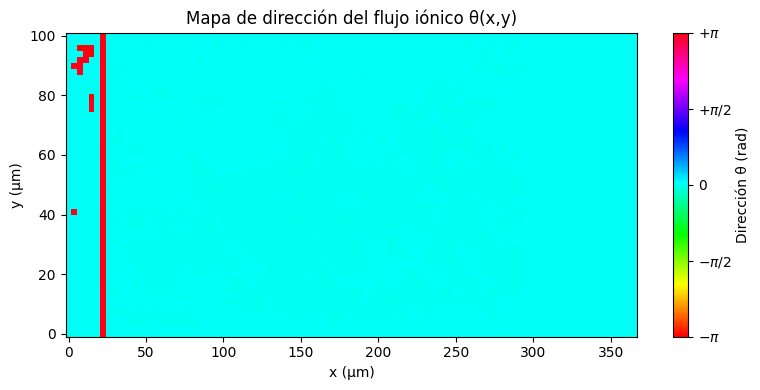

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.constants import R, physical_constants


# 1) Calcula Jx, Jy
Jx = -D_ion_xy * dc_dx + z * mu_xy * c_ion * Ex
Jy = -D_ion_xy * dc_dy + z * mu_xy * c_ion * Ey

# 2) Ángulo θ = atan2(Jy,Jx)
theta = np.arctan2(Jy, Jx)  # radianes en [-π,π]

# 3) Plot 1: map of θ
plt.figure(figsize=(8,4))
pcm = plt.pcolormesh(
    X*1e6, Y*1e6,
    theta,
    cmap='hsv',
    vmin=-np.pi,
    vmax= np.pi,
    shading='auto'
)
cbar = plt.colorbar(pcm, label='Dirección θ (rad)')
cbar.set_ticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi])
cbar.set_ticklabels(['$-\\pi$','$-\\pi/2$','0','$+\\pi/2$','$+\\pi$'])
plt.xlabel('x (µm)')
plt.ylabel('y (µm)')
plt.title('Mapa de dirección del flujo iónico θ(x,y)')
plt.tight_layout()
plt.show()



In [16]:
print('Jmag minimo',Jmag.min())
print('Jmag maximo',Jmag.max())

Jmag minimo 0.0
Jmag maximo 0.0005852851377444884


In [ ]:
idx_nmc = materials.index("NMC811 (con grafeno)")
idx_llzo = materials.index("LLZO")

Jmag_nmc = Jmag[region == idx_nmc].flatten()
Jmag_llzo = Jmag[region == idx_llzo].flatten()

print("Valores típicos en NMC:", np.percentile(Jmag_nmc, [0, 50, 99, 100]))
print("Valores típicos en LLZO:", np.percentile(Jmag_llzo, [0, 50, 99, 100]))


Valores típicos en NMC: [1.76905887e-11 1.76906665e-11 5.49008458e-05 5.49008458e-05]
Valores típicos en LLZO: [7.08513971e-05 1.07115354e-04 5.85285138e-04 5.85285138e-04]


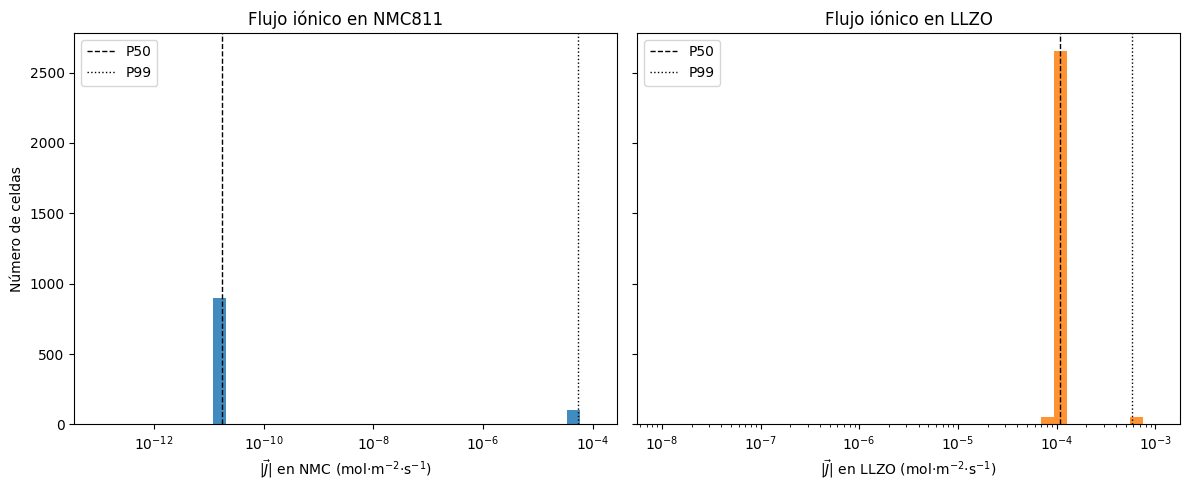

In [24]:
import numpy as np
import matplotlib.pyplot as plt

# Máscaras
mask_nmc  = (region == idx_nmc)
mask_llzo = (region == idx_llzo)

# Valores de flujo (con clip para evitar ceros exactos)
eps = 1e-20
Jn = np.clip(Jmag[mask_nmc].flatten(),  eps, None)
Jl = np.clip(Jmag[mask_llzo].flatten(), eps, None)

# Bins específicos para cada material
bins_nmc  = np.logspace(np.log10(1e-13), np.log10(1e-4), 40)
bins_llzo = np.logspace(np.log10(1e-8),  np.log10(1e-3), 40)

fig, axs = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

# --- NMC -------------------------------------------------
axs[0].hist(Jn, bins=bins_nmc, color='tab:blue', alpha=0.85)
axs[0].set_xscale('log')
axs[0].set_xlabel(r'$|\vec{J}|$ en NMC (mol·m$^{-2}$·s$^{-1}$)')
axs[0].set_ylabel("Número de celdas")
axs[0].set_title("Flujo iónico en NMC811")
p50, p99 = np.percentile(Jn, [50, 99])
axs[0].axvline(p50, color='k', ls='--', lw=1, label='P50')
axs[0].axvline(p99, color='k', ls=':',  lw=1, label='P99')
axs[0].legend()

# --- LLZO ------------------------------------------------
axs[1].hist(Jl, bins=bins_llzo, color='tab:orange', alpha=0.85)
axs[1].set_xscale('log')
axs[1].set_xlabel(r'$|\vec{J}|$ en LLZO (mol·m$^{-2}$·s$^{-1}$)')
axs[1].set_title("Flujo iónico en LLZO")
p50l, p99l = np.percentile(Jl, [50, 99])
axs[1].axvline(p50l, color='k', ls='--', lw=1, label='P50')
axs[1].axvline(p99l, color='k', ls=':',  lw=1, label='P99')
axs[1].legend()

plt.tight_layout()
plt.show()


### Interpretación de los resultados

- **Regiones metálicas** (Aluminio y Li metálico):  
  No hay concentración móvil de Li\(^+\), por lo que \(\mathbf J\approx 0\).

- **Capas activas** (NMC811 y LLZO):  
  Se observa un flujo predominantemente en la dirección \(+x\) (hacia el ánodo),  
  debido a la componente migratoria \(\mu\,c\,E\) que supera a la difusiva \(-D\nabla c\).

- **Orden de magnitud**  \
  \(\lvert \mathbf J\rvert\sim 10^{-10}\,\mathrm{mol/(m^2·s)}\) es coherente con  
  \[
    j = F\,J_x \sim 10^{-10}\times10^5 \approx 10^{-5}\,\mathrm{A/m^2},
  \]  
  muy bajo (circuito casi abierto).

- **Equilibrio OCV**  
  En verdadero circuito abierto el flujo neto debe anularse (\(\mathbf J=0\)).  
  Si \(\mathbf J\neq0\) significa que la distribución \(c(x,y)\) inicial no es aún el perfil de equilibrio Nernst–Planck.  




## Concentracion de iones en un ciclo de descarga

###  CÁLCULO DEL dt CORRECTO (Estabilidad de difusión/migración)
El paso de tiempo seguro para ecuaciones de difusión-migración 2D viene dado por la condición de estabilidad de tipo CFL (Courant–Friedrichs–Lewy):

𝑑
𝑡
<
1
4
⋅
min
⁡
(
𝑑
𝑥
,
𝑑
𝑦
)
2
𝐷
𝑚
𝑎
𝑥
dt< 
4
1
​
 ⋅ 
D 
max
​
 
min(dx,dy) 
2
 
​
 

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib.colors import LogNorm
from IPython.display import HTML
from scipy.sparse import lil_matrix
from scipy.sparse.linalg import spsolve
from scipy.constants import physical_constants
from numba import njit, prange

# ─────────────────────── 0. CONSTANTES Y ARRAYS (iguales a tu código) ────────────────────────
F = physical_constants["Faraday constant"][0]
R = physical_constants["molar gas constant"][0]
T = 298.15
z = 1
SOC_ini = 0.88
η = 0.05
c_ref = 4.60e4
σ_min, D_min = 1e-20, 1e-20

# … resto de arrays: materials, region2, D0_arr, σe_arr, etc. (idéntico a tu bloque) …

# ───────────────────────── 1. FUNCIÓN JIT PARA D, σ ──────────────────────────
@njit(parallel=True)
def D_sigma_mu_jit(c, region, D0_arr, σe_arr, c_ref,
                   idx_nmc, idx_llzo, idx_intf1, idx_intf2):
    Ny, Nx = c.shape
    D_xy = np.empty((Ny, Nx))
    σ_xy = np.empty((Ny, Nx))
    for i in prange(Ny):
        for j in range(Nx):
            k = region[i, j]
            D0, σe = D0_arr[k], σe_arr[k]
            if k == idx_nmc:                       # difusión dependiente de SOC
                SOC = min(max(c[i, j] / c_ref, 1e-4), 1.0)
                Dloc = D0 * np.exp(-5 * (1 - SOC))
                σloc = Dloc * F**2 * c[i, j] / (R * T)
            elif k in (idx_llzo, idx_intf1, idx_intf2):  # LLZO + interfaces
                Dloc = D0
                σloc = D0 * F**2 * c[i, j] / (R * T)
            else:                                       # metales
                Dloc, σloc = D0, σe
            # mínimos numéricos
            D_xy[i, j] = Dloc if Dloc > D_min else D_min
            σ_xy[i, j] = σloc if σloc > σ_min else σ_min
    return D_xy, σ_xy

# ───────────────────────── 2. SOLVER φ (sin cambios) ─────────────────────────
def solve_phi(E_ocv, η, σ_xy):
    Ny, Nx = region2.shape
    dx, dy = X2[0,1] - X2[0,0], Y2[1,0] - Y2[0,0]
    idx = lambda i, j: i * Nx + j
    A = lil_matrix((Ny * Nx, Ny * Nx));  b = np.zeros(Ny * Nx)
    for i in range(Ny):
        for j in range(Nx):
            k = idx(i, j)
            if j == 0:                       # Neumann Al
                A[k, k], A[k, idx(i, j+1)] = 1, -1
            elif j == j_if_col:              # Dirichlet NMC
                A[k, k];   b[k] = E_ocv + η
            elif j == Nx - 1:                # Dirichlet Li
                A[k, k] = 1
            elif i == 0:                     # Neumann sup/inf
                A[k, k], A[k, idx(i+1, j)] = 1, -1
            elif i == Ny - 1:
                A[k, k], A[k, idx(i-1, j)] = 1, -1
            else:                            # interior
                sl, sr = σ_xy[i, j-1], σ_xy[i, j+1]
                su, sd = σ_xy[i-1, j], σ_xy[i+1, j]
                A[k, k] = -(sl+sr)/dx**2 - (su+sd)/dy**2
                A[k, idx(i, j-1)], A[k, idx(i, j+1)] = sl/dx**2, sr/dx**2
                A[k, idx(i-1, j)], A[k, idx(i+1, j)] = su/dy**2, sd/dy**2
    return spsolve(A.tocsr(), b).reshape(Ny, Nx)

# ───────────────────────── 3. BUCLE TEMPORAL ─────────────────────────
c = np.zeros_like(region2, dtype=float)
c[region2 == idx_nmc] = SOC_ini * c_ref

frames_c, frames_E, frames_J = [], [], []  # para animaciones
E_avg_llzo, E_max_llzo = [], []
J_avg_llzo, J_max_llzo = [], []

for f in range(frames):
    for _ in range(steps_per_frame):
        D_xy, σ_xy = D_sigma_mu_jit(c, region2, D0_arr, σe_arr, c_ref,
                                    idx_nmc, idx_llzo, idx_intf1, idx_intf2)
        φ = solve_phi(4.1967, η, σ_xy)
        dc_dy, dc_dx = np.gradient(c, dy, dx)
        Ey, Ex = np.gradient(-φ, dy, dx)
        Jx = -D_xy * dc_dx + z * (D_xy * F / (R * T)) * c * Ex
        Jy = -D_xy * dc_dy + z * (D_xy * F / (R * T)) * c * Ey
        divJ = np.gradient(Jx, dx, axis=1) + np.gradient(Jy, dy, axis=0)
        # transferencia NMC→LLZO
        delta = j_if * dt / dx
        cn = np.clip(c[:, j_if_col] - delta, 0, None)
        transfer = c[:, j_if_col] - cn
        c[:, j_if_col] = cn
        c[:, j_if_col + 1] += transfer
        c += -dt * divJ
        c = np.clip(c, 0, None)
        c[region2 == idx_li] = 0

    # guardar cada frame
    frames_c.append(c.copy())
    E_mag = np.hypot(Ex, Ey);      frames_E.append(E_mag)
    J_mag = np.hypot(Jx, Jy);      frames_J.append(J_mag)

    mask_llzo = (region2 == idx_llzo)
    E_avg_llzo.append(E_mag[mask_llzo].mean());  E_max_llzo.append(E_mag[mask_llzo].max())
    J_avg_llzo.append(J_mag[mask_llzo].mean());  J_max_llzo.append(J_mag[mask_llzo].max())

# ───────────────────────── 4. FUNCIONES DE ANIMACIÓN ─────────────────────────
extent = [0, Lx*1e6, 0, Ly*1e6]
def animate(frames, cmap, vmin=None, vmax=None, label=''):
    fig, ax = plt.subplots(figsize=(6, 3))
    vmin = vmin or max(1e-20, min(f[f>0].min() for f in frames))
    vmax = vmax or max(f.max() for f in frames)
    norm = LogNorm(vmin=vmin, vmax=vmax)
    im = ax.imshow(frames[0], origin='lower', extent=extent,
                   cmap=cmap, norm=norm)
    cb = fig.colorbar(im, ax=ax, label=label)
    def upd(i):
        im.set_data(frames[i]); ax.set_title(f'frame {i}/{len(frames)-1}')
        return [im]
    return HTML(FuncAnimation(fig, upd, frames=len(frames), interval=200,
                              blit=True).to_jshtml())

# Animaciones (comenta las que no necesites)
anim_c   = animate(frames_c, cmap='plasma', label='c Li⁺ (mol/m³)')
anim_E   = animate(frames_E, cmap='inferno', label='|E| (V/m)')
anim_J   = animate(frames_J, cmap='plasma', label='|J| (mol m$^{-2}$ s$^{-1}$)')

# ───────────────────────── 5. GRÁFICAS VS TIEMPO ─────────────────────────
time_vec = np.arange(len(frames_c)) * steps_per_frame * dt / 60  # minutos

plt.figure(figsize=(8,3))
plt.plot(time_vec, E_avg_llzo, '-o', label='⟨|E|⟩ LLZO')
plt.plot(time_vec, E_max_llzo, '-s', label='max |E| LLZO')
plt.xlabel('t (min)'); plt.ylabel('|E| (V/m)'); plt.legend(); plt.grid(True)
plt.tight_layout(); plt.show()

plt.figure(figsize=(8,3))
plt.plot(time_vec, J_avg_llzo, '-o', label='⟨|J|⟩ LLZO')
plt.plot(time_vec, J_max_llzo, '-s', label='max |J| LLZO')
plt.xlabel('t (min)'); plt.ylabel('|J| (mol m$^{-2}$ s$^{-1}$)')
plt.yscale('log'); plt.legend(); plt.grid(True, which='both', ls='--')
plt.tight_layout(); plt.show()


NameError: name 'region2' is not defined

### 3 codigo

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import lil_matrix
from scipy.sparse.linalg import spsolve
from scipy.constants import physical_constants

# ───────────────────────────────────────── 0. CONSTANTES ─────────────────────────────────────────
F       = physical_constants["Faraday constant"][0]
R       = physical_constants["molar gas constant"][0]
T       = 298.15        # K
z       = 1
SOC_ini = 0.88          # SOC inicial del cátodo
η       = 0.05          # sobrepotencial fija

# — Umbrales mínimos para evitar singularidades numéricas —
σ_min = 1e-20   # S/m
D_min = 1e-20   # m²/s

# ───────────────────────────────────────── 1. ESTADO INICIAL ────────────────────────────────────
idx_nmc  = materials.index("NMC811 (con grafeno)")
mask_nmc = region == idx_nmc
c_ref    = 4.60e4                       # mol·m⁻³
c        = np.zeros_like(region, dtype=float)
c[mask_nmc] = SOC_ini * c_ref           # Li⁺ inicial sólo en NMC

# ───────────────────────── helpers que dependen de la concentración ─────────────────────────────
def D_sigma_mu(c):
    D_xy = np.zeros_like(c)
    σ_xy = np.zeros_like(c)
    for k, mat in enumerate(materials):
        msk = (region == k)
        D0  = propiedades_lit[mat]["difusion_ionica"]
        σ_e = propiedades_lit[mat]["sigma_electronica"]
        if mat == "NMC811 (con grafeno)":
            SOC   = np.clip(c[msk]/c_ref, 1e-4, 1)
            D_loc = D0 * np.exp(-5*(1-SOC))
            D_xy[msk] = D_loc
            σ_xy[msk] = D_loc * F**2 * c[msk] / (R*T)
        elif mat in ("LLZO", "NMC|LLZO", "LLZO|Li"):
            D_xy[msk] = D0
            σ_xy[msk] = D0 * F**2 * c[msk] / (R*T)
        else:  # metales
            D_xy[msk] = D0
            σ_xy[msk] = σ_e

    # imponemos mínimos para evitar filas nulas
    D_xy = np.where(D_xy < D_min, D_min, D_xy)
    σ_xy = np.where(σ_xy < σ_min, σ_min, σ_xy)

    μ_xy = D_xy * F / (R*T)
    return D_xy, σ_xy, μ_xy

def solve_phi(E_ocv, η, σ_xy):
    """Resuelve ∇·(σ∇φ)=0 con φ=E_ocv+η en NMC, φ=0 en Li."""
    Ny, Nx = region.shape
    dx, dy = X[0,1]-X[0,0], Y[1,0]-Y[0,0]
    idx_flat = lambda i,j: i*Nx + j
    nmc_col  = np.where(region[0] == idx_nmc)[0][-1]

    # refuerza mínimo
    σ_xy = np.where(σ_xy < σ_min, σ_min, σ_xy)

    A = lil_matrix((Ny*Nx, Ny*Nx))
    b = np.zeros(Ny*Nx)

    for i in range(Ny):
        for j in range(Nx):
            k = idx_flat(i,j)
            if j == 0:
                A[k,k], A[k,idx_flat(i,j+1)] = 1, -1
            elif j == nmc_col:
                A[k,k] = 1
                b[k]   = E_ocv + η
            elif j == Nx-1:
                A[k,k] = 1
            elif i == 0:
                A[k,k], A[k,idx_flat(i+1,j)] = 1, -1
            elif i == Ny-1:
                A[k,k], A[k,idx_flat(i-1,j)] = 1, -1
            else:
                sl, sr = σ_xy[i,j-1], σ_xy[i,j+1]
                su, sd = σ_xy[i-1,j], σ_xy[i+1,j]
                A[k,k] = -(sl+sr)/dx**2 - (su+sd)/dy**2
                A[k,idx_flat(i,j-1)] = sl/dx**2
                A[k,idx_flat(i,j+1)] = sr/dx**2
                A[k,idx_flat(i-1,j)] = su/dy**2
                A[k,idx_flat(i+1,j)] = sd/dy**2

    return spsolve(A.tocsr(), b).reshape(Ny, Nx)

# ────────────────────── 2. CORRIENTE DE DESCARGA A 2 C ─────────────────────────────
# Carga total por unidad de área (C·m⁻²)
Q_area = df_moles_por_m2["Moles Li⁺ efectivos por m²"].sum() * F  

# Corriente aplicada a 2 C (A·m⁻²), sabiendo que 1 C = Q_area en 1 h = 3600 s
I_app  = 2 * Q_area / 3600                                      

# Flujo iónico mol·m⁻²·s⁻¹ extraído del cátodo
j_if   = I_app / F                                               

# Índice de la última columna de NMC en tu rejilla 2D
j_if_col = np.where(region[0] == materials.index("NMC811 (con grafeno)"))[0][-1]

print(f"Descarga a 2 C  ⇒  j_if = {j_if:.3e} mol·m⁻²·s⁻¹ (interfaz en columna {j_if_col})")

# ───────────── 3. CÁLCULO DE dt SEGURA ─────────────────────────────────────
dx, dy      = X[0,1]-X[0,0], Y[1,0]-Y[0,0]
D_max       = max(propiedades_lit[m]["difusion_ionica"] for m in materials)
dt_safe     = 0.25 * min(dx,dy)**2 / D_max
dt          = dt_safe * 0.95             # < dt_safe para estabilidad
sim_hours   = 0.5
nsteps      = int(sim_hours * 3600 / dt)
check_every = 2000
print(f"dt segura: {dt_safe:.2e}s → usando dt={dt:.2e}s en {nsteps} pasos")

E_ocv = 4.1967

# ───────────────────────────── 4. LOOP TEMPORAL ──────────────────────────────────────────────
idx_li    = materials.index("Li")
cell_area = dx * dy

stores = {"c":[], "phi":[], "li":[]}
for step in range(nsteps+1):
    D_xy, σ_xy, μ_xy = D_sigma_mu(c)
    ϕ = solve_phi(E_ocv, η, σ_xy)

    dc_dy, dc_dx = np.gradient(c, dy, dx)
    Ey, Ex       = np.gradient(-ϕ, dy, dx)
    Jx = -D_xy*dc_dx + z*μ_xy*c*Ex
    Jy = -D_xy*dc_dy + z*μ_xy*c*Ey
    divJ = np.gradient(Jx, dx, axis=1) + np.gradient(Jy, dy, axis=0)

    # transferencia conservativa en interfaz NMC|LLZO
    delta_c = j_if * dt / dx
    c_nmc   = np.clip(c[:,j_if_col] - delta_c, 0, None)
    transfer= c[:,j_if_col] - c_nmc
    c[:,j_if_col]   = c_nmc
    c[:,j_if_col+1] += transfer

    # continuidad
    c += -dt * divJ
    c = np.clip(c, 0, None)
    c[region == idx_li] = 0  # sumidero Li

    # monitoriza
    if step % check_every == 0 or step == nsteps:
        stores["c"].append(c.copy())
        stores["phi"].append(ϕ.copy())
        li_tot = c.sum() * cell_area
        stores["li"].append(li_tot)
        print(f"Paso {step:6d} | Li total = {li_tot:.3e} mol | max(c)={c.max():.2e}")

# ─────────────────────────── 5. VISUALIZACIÓN FINAL ─────────────────────────────────────
plt.figure()
plt.plot(np.arange(len(stores["li"]))*check_every*dt/60, stores["li"], 'o-')
plt.xlabel("Tiempo (min)"); plt.ylabel("Li total (mol)")
plt.title("Descarga de Li⁺"); plt.grid(); plt.show()

plt.figure(figsize=(10,4))
plt.imshow(stores["c"][-1], origin='lower',
           extent=[X.min()*1e6, X.max()*1e6, Y.min()*1e6, Y.max()*1e6],
           aspect='auto', cmap='plasma')
plt.colorbar(label='c Li⁺ (mol/m³)')
plt.xlabel('x (μm)'); plt.ylabel('y (μm)')
plt.title(f'Li⁺ tras {sim_hours*60:.0f} min')
plt.tight_layout(); plt.show()
